##Data preprocessing

Before training, perform simple preprocessing on the data set and check the basic format of the data.

In [1]:
# Import package
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal
from biosppy.signals import ecg
import neurokit2 as nk
from sklearn import *
from collections import OrderedDict

## Read file


In [2]:
#Set the read file path
path = 'D:/Test Jupyter/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl/'

X = np.load(path + 'raw100.npy', allow_pickle=True)
sampling_rate = 100

In [3]:

# Read the file and convert tags
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
Y.head

<bound method NDFrame.head of         patient_id   age  sex  height  weight  nurse  site      device  \
ecg_id                                                                   
1          15709.0  56.0    1     NaN    63.0    2.0   0.0   CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0   CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0   CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0   CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0   CS-12   E   
...            ...   ...  ...     ...     ...    ...   ...         ...   
21833      17180.0  67.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21834      20703.0  93.0    0     NaN     NaN    1.0   2.0  AT-60    3   
21835      19311.0  59.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21836       8873.0  64.0    1     NaN     NaN    1.0   2.0  AT-60    3   
21837      11744.0  68.0    0     NaN     NaN    1.0   2.0  AT-60    3   

       

In [5]:
Y.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21837, dtype: object

In [6]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [7]:

# Get original signal data
# X = load_raw_data(Y, sampling_rate, path)

In [8]:
X.shape

(21837, 1000, 12)

In [9]:

# Get diagnostic information in scp_statements.csv
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [10]:
agg_df.head

<bound method NDFrame.head of                                              description  diagnostic  form  \
NDT                       non-diagnostic T abnormalities         1.0   1.0   
NST_                             non-specific ST changes         1.0   1.0   
DIG                                     digitalis-effect         1.0   1.0   
LNGQT                                   long QT-interval         1.0   1.0   
NORM                                          normal ECG         1.0   NaN   
...                                                  ...         ...   ...   
BIGU   bigeminal pattern (unknown origin, SV or Ventr...         NaN   NaN   
AFLT                                      atrial flutter         NaN   NaN   
SVTAC                       supraventricular tachycardia         NaN   NaN   
PSVT             paroxysmal supraventricular tachycardia         NaN   NaN   
TRIGU  trigeminal pattern (unknown origin, SV or Vent...         NaN   NaN   

       rhythm diagnostic_class di

In [11]:
agg_df = agg_df[agg_df.diagnostic == 1]

In [12]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in agg_df.index:
            res.add(agg_df.loc[k].diagnostic_class)
    return list(res)

In [13]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [14]:
Y['scp_classes'] = Y.scp_codes.apply(diagnostic_class)

In [15]:
Z = pd.DataFrame(0, index=Y.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in Y.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

NORM  MI  STTC  CD  HYP
ecg_id                         
1          1   0     0   0    0
2          1   0     0   0    0
3          1   0     0   0    0
4          1   0     0   0    0
5          1   0     0   0    0
...      ...  ..   ...  ..  ...
21833      0   0     1   0    0
21834      1   0     0   0    0
21835      0   0     1   0    0
21836      1   0     0   0    0
21837      1   0     0   0    0

[21837 rows x 5 columns]

In [16]:
#Add diagnostic information
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [17]:
Y[['scp_codes', 'scp_classes', 'diagnostic_superclass']]

scp_codes scp_classes  \
ecg_id                                                                  
1                {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}      [NORM]   
2                            {'NORM': 80.0, 'SBRAD': 0.0}      [NORM]   
3                              {'NORM': 100.0, 'SR': 0.0}      [NORM]   
4                              {'NORM': 100.0, 'SR': 0.0}      [NORM]   
5                              {'NORM': 100.0, 'SR': 0.0}      [NORM]   
...                                                   ...         ...   
21833   {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...      [STTC]   
21834            {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}      [NORM]   
21835                          {'ISCAS': 50.0, 'SR': 0.0}      [STTC]   
21836                          {'NORM': 100.0, 'SR': 0.0}      [NORM]   
21837                          {'NORM': 100.0, 'SR': 0.0}      [NORM]   

       diagnostic_superclass  
ecg_id                        
1                     [NORM]  
2                     [NORM]  
3                     [NORM]  
4                     [NORM]  
5                     [NORM]  
...                      ...  
21833                 [STTC]  
21834                 [NORM]  
21835                 [STTC]  
21836                 [NORM]  
21837                 [NORM]  

[21837 rows x 3 columns]

In [18]:
check_y=Y.loc[Y.index == 40, ['scp_codes', 'scp_classes', 'diagnostic_superclass']]
check_y

scp_codes scp_classes diagnostic_superclass
ecg_id                                                             
40      {'NORM': 80.0, 'SR': 0.0}      [NORM]                [NORM]

In [19]:
Y.diagnostic_superclass.value_counts()

diagnostic_superclass
[NORM]                 9083
[MI]                   2538
[STTC]                 2406
[CD]                   1709
[CD, MI]               1302
[STTC, HYP]             783
[MI, STTC]              602
[HYP]                   536
[CD, STTC]              472
[]                      407
[NORM, CD]              407
[MI, STTC, HYP]         362
[CD, HYP]               300
[CD, MI, STTC]          223
[CD, STTC, HYP]         211
[MI, HYP]               183
[CD, MI, STTC, HYP]     158
[CD, MI, HYP]           117
[NORM, STTC]             28
[NORM, CD, STTC]          5
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, CD, MI, HYP]       1
Name: count, dtype: int64

In [20]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'scp_classes', 'diagnostic_superclass'],
      dtype='object')


## Plot to view original data

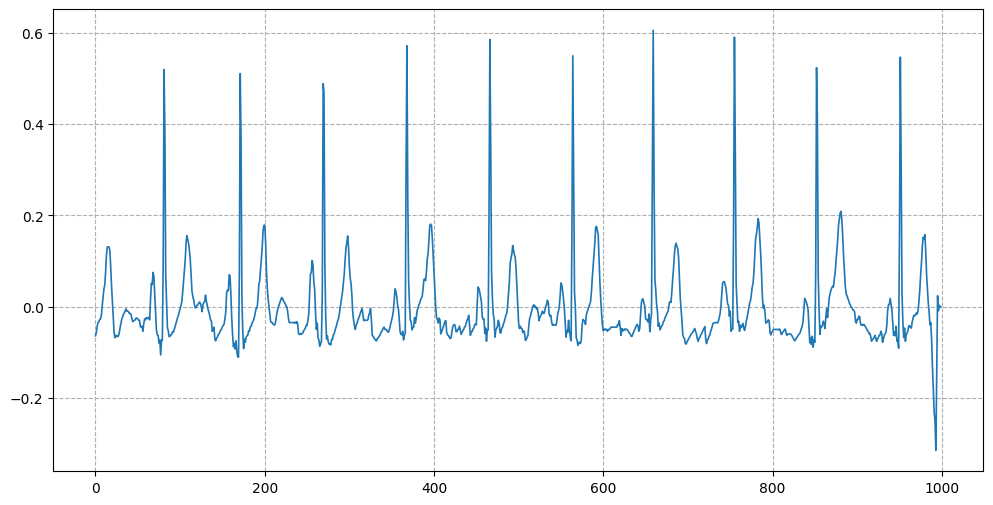

In [14]:
plt.rcParams['figure.figsize'] = (12,6) 
plt.figure()
# plt.plot(X[3165][:,1], linewidth=1.2)
plt.plot(X[7476][:,1], linewidth=1.2)
plt.grid(linestyle='--')
# plt.yticks([])
plt.show()

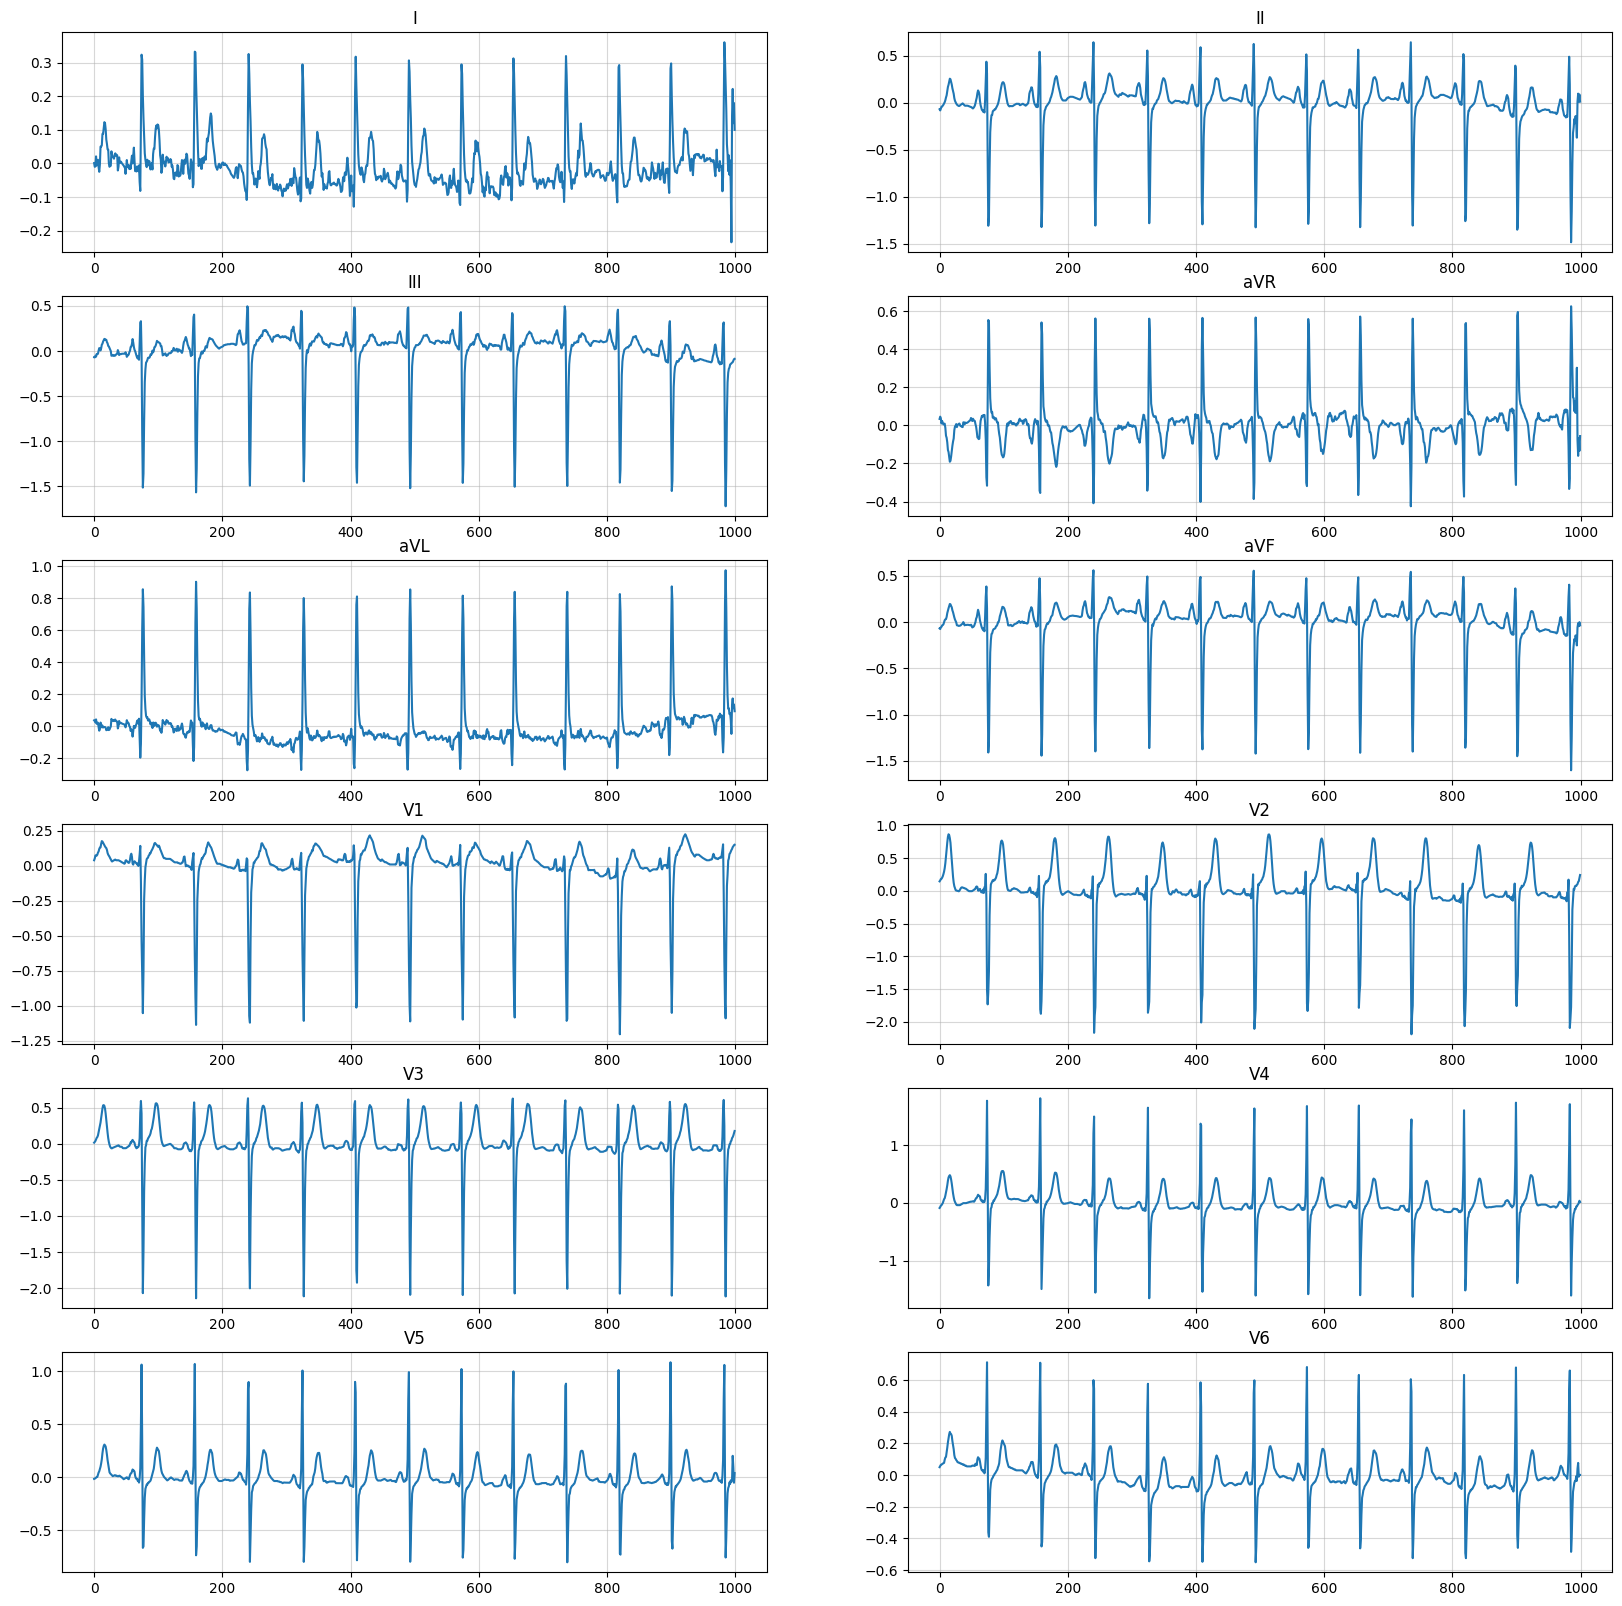

In [22]:
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
for i in range(12):
    plt.subplot(6, 2, i+1)
    plt.plot(X[40,:,i])
    plt.title(titles[i])
plt.show()


## ECG filtering to remove baseline drift and segmentation

In [23]:
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))


### Five-point smoothing filter

In [24]:
ecg_original = X[40][:,0]
ecg_filtered = np_move_avg(ecg_original, 5)

In [25]:
#fft transform to view the spectrum
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = sampling_rate
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg

In [26]:
def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    plt.rcParams['figure.figsize'] = (20.0, 10.0)
    plt.rcParams["axes.grid"] = True
    plt.rcParams["grid.linestyle"] = (0.1,0.1)
    plt.rcParams['axes.titlesize'] = 16
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:100])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:100])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

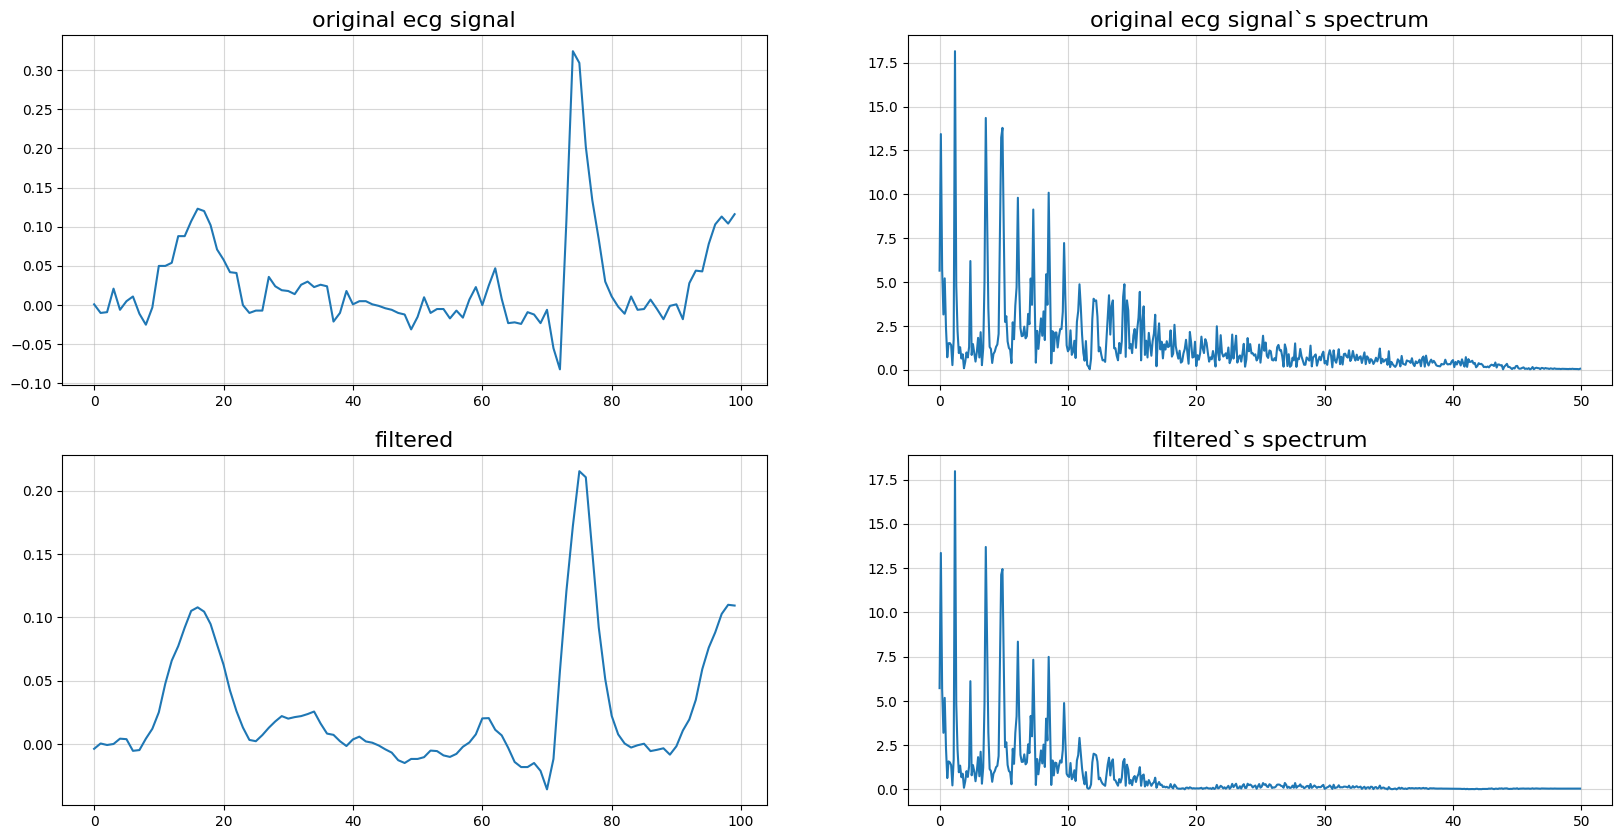

In [27]:
show_spec_dif(ecg_original, ecg_filtered, 'original ecg signal', 'filtered')

In [28]:
# Remove all lead noise
channels = 12
for index in range(len(X)):
    for channel in range(channels):
        X[index][:, channel] = np_move_avg(X[index][:, channel], 5)

In [29]:
X.shape

(21837, 1000, 12)

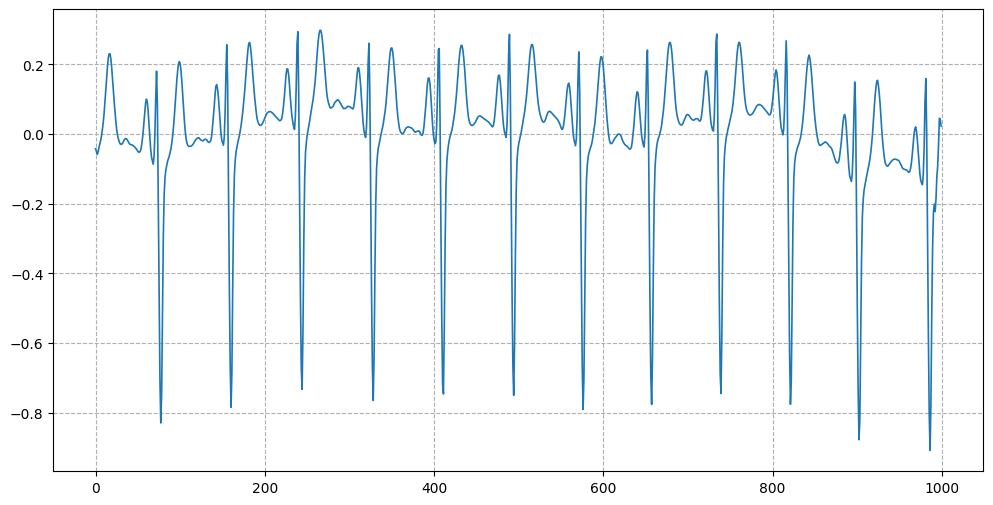

In [30]:
plt.rcParams['figure.figsize'] = (12,6) 
# plt.rcParams["axes.grid"] = True
# plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
plt.plot(X[40][:,1], linewidth=1.2)
plt.grid(linestyle='--')
# plt.yticks([])
plt.show()

## Baseline drift

Use a high-pass filter to remove baseline drift. Baseline drift is a low-frequency interference. The frequency range is usually less than 1Hz, most of which are concentrated at 0.1Hz. It usually appears near the ST segment and Q wave.

The sampling frequency of the signal here is 500Hz. To filter out the baseline drift, obtain the baseline drift through a high-pass filter, and then subtract the baseline drift from the original signal to obtain the ECG signal without baseline drift.

The filter design is as follows:

The cutoff frequency is 0.1Hz, $wn=2*0.1/1000=0.0002$

In [47]:
# b, a = signal.butter(8, 0.01, 'highpass')
# baseline = signal.filtfilt(b, a, ecg_filtered)

In [32]:
# diff = ecg_filtered-baseline
# plt.figure()
# plt.subplot(311)
# plt.plot(ecg_filtered[:1000])
# plt.subplot(312)
# plt.plot(baseline[:1000])
# plt.subplot(313)
# plt.plot(diff[:1000])
# plt.show()

>The referenced paper did not remove noise. There is no noise removal here. Try to remove baseline drift.

## PQRST peaks detection

In [3]:
X.shape

(21837, 1000, 12)

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn import *
from collections import OrderedDict

def ecg_process(ecg, smp_rate, visualize=False):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=smp_rate)
    
    # R peaks + correct peaks
    inst_rpeaks, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=smp_rate, correct_artifacts=True)
    rpeaks.update({'ECG_R_Peaks':list(OrderedDict.fromkeys(rpeaks['ECG_R_Peaks']))})
    
    # Signal rate + signal quality
    rate = nk.ecg_rate(rpeaks, sampling_rate=smp_rate, desired_length=len(ecg_clean))
    quality = nk.ecg_quality(ecg_clean, rpeaks=None, sampling_rate=smp_rate)
    
    # P, Q, S, T peaks, P onset, T offset
    inst_peaks, peaks = nk.ecg_delineate(ecg_clean, rpeaks=rpeaks, sampling_rate=smp_rate, method='peak', show=visualize, show_type='all')

    # Cardiac phase 0/1 + perc completion
    cardiac_phase = nk.ecg_phase(ecg_clean, rpeaks=rpeaks, delineate_info=peaks, sampling_rate=smp_rate)
    
    # group information
    peak_info = {**rpeaks, **peaks}
    signal = pd.DataFrame({"ECG_Raw":ecg, "ECG_Clean":ecg_clean, "ECG_Rate":rate, "ECG_Quality":quality})
    signal = pd.concat([signal, inst_rpeaks, inst_peaks, cardiac_phase], axis=1)
    
    if visualize:
        # raw vs. clean ecg 
        plt.plot(range(0, len(ecg)), ecg)
        plt.plot(range(0, len(ecg_clean)), ecg_clean)
        # R peaks
        nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_clean) 
        # summary plot
        nk.ecg_plot(signal, sampling_rate=smp_rate)
    
    return signal, peak_info


def replace_peak_nan(peak_list):
    #replace nans with corresp. median distance between peaks  
    peak_list = np.array(peak_list)
    diff_list = np.diff(peak_list)
    
    #case if nans cause diff_list to be empty
    if(np.all(np.isnan(diff_list))):
        ind_non_nan = np.where(~np.isnan(peak_list))[0]
        diff_list = []           
        for i in range(0, len(ind_non_nan)-1):
            ind, next_ind = ind_non_nan[i], ind_non_nan[i+1]
            diff = (peak_list[next_ind] - peak_list[ind])/(next_ind - ind)
            diff_list.append(diff)
        insert_val = int(np.min(diff_list))
    else:
        insert_val = int(np.nanmedian(diff_list))
   
    ind_nan = np.where(np.isnan(peak_list))[0]
    
    #case if nan at first index
    if (0 in ind_nan):
        next_non_nan = next(val for val in peak_list if ~np.isnan(val))
        ind_next = np.where(peak_list == next_non_nan)[0][0]
        peak_list[0] = next_non_nan - ind_next * insert_val
        ind_nan = np.delete(ind_nan, 0)

    for ind in ind_nan:
        peak_list[ind] = peak_list[ind-1] + insert_val
    
    #case if calc peak out of bounds        
    if (np.any(peak_list > len(ecg))):
        ind_outofbound = np.where(peak_list > len(ecg))[0]
        for ind in ind_outofbound:
            peak_list[ind] = len(ecg)-1
        
    return list(peak_list.astype(int))


def extract_features(signal, peak_info, smp_rate, visualize=False):
    
    ecg_clean = np.array(signal['ECG_Clean'])
    
    # hrv features (mod)
    # hrv = nk.hrv(peak_info, sampling_rate=smp_rate, show=visualize).squeeze()
    # capen = pd.Series([nk.complexity_capen(ecg_clean)], index=['HRV_CApEn'])
    # hrv.drop(['HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF'
    #           , 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_ApEn', 'HRV_SampEn'], inplace=True)
    # hrv = hrv.append(capen)

    #replace peak_info dictionary nans with values
    peak_info.update({'ECG_P_Peaks':replace_peak_nan(peak_info['ECG_P_Peaks'])})
    peak_info.update({'ECG_Q_Peaks':replace_peak_nan(peak_info['ECG_Q_Peaks'])})
    peak_info.update({'ECG_R_Peaks':replace_peak_nan(peak_info['ECG_R_Peaks'])})
    peak_info.update({'ECG_S_Peaks':replace_peak_nan(peak_info['ECG_S_Peaks'])})
    peak_info.update({'ECG_T_Peaks':replace_peak_nan(peak_info['ECG_T_Peaks'])})
    peak_info.update({'ECG_P_Onsets':replace_peak_nan(peak_info['ECG_P_Onsets'])})
    peak_info.update({'ECG_T_Offsets':replace_peak_nan(peak_info['ECG_T_Offsets'])})    

    manual_feat = {}
    
    #min, max, mean, std, interqt of heart rate + max, mean, std, interqt diff in heart rate
    rate = np.array(signal['ECG_Rate'])
    diff_rate = np.diff(rate)
    manual_feat.update({'MF_MinRate':np.min(rate), 'MF_MaxRate':np.max(rate)
                    , 'MF_MeanRate':np.mean(rate), 'MF_StdRate':np.std(rate)
                    , 'MF_InterQtRate':(np.quantile(rate, .75) - np.quantile(rate, .25))
                    , 'MF_MaxDiffRate':np.max(diff_rate), 'MF_MeanDiffRate':np.mean(diff_rate)
                    , 'MF_StdDiffRate':np.std(diff_rate)
                    , 'MF_InterQtDiffRate':(np.quantile(diff_rate, .75) - np.quantile(diff_rate, .25))})
    
    #min, max, mean, std, interqt of quality + max, mean, std, interqt diff in quality
    quality = np.array(signal['ECG_Quality'])
    diff_quality = np.diff(quality)
    manual_feat.update({'MF_MinQuality':np.min(quality), 'MF_MaxQuality':np.max(quality)
                    , 'MF_MeanQuality':np.mean(quality), 'MF_StdQuality':np.std(quality)
                    , 'MF_InterQtQuality':(np.quantile(quality, .75) - np.quantile(quality, .25))
                    , 'MF_MaxDiffQuality':np.max(diff_quality), 'MF_MeanDiffQuality':np.mean(diff_quality)
                    , 'MF_StdDiffQuality':np.std(diff_quality)
                    , 'MF_InterQtDiffQuality':(np.quantile(diff_quality, .75) - np.quantile(diff_quality, .25))})
    
    #min, max, mean, std, interqt values of P, Q, R, S, T peaks + mean, std of ecg signal + count zero crossings
    count_zerocross = nk.signal_zerocrossings(ecg_clean).shape[0]
    peak_P = ecg_clean[peak_info['ECG_P_Peaks']]
    peak_Q = ecg_clean[peak_info['ECG_Q_Peaks']]
    peak_R = ecg_clean[peak_info['ECG_R_Peaks']]
    peak_S = ecg_clean[peak_info['ECG_S_Peaks']]
    peak_T = ecg_clean[peak_info['ECG_T_Peaks']]
    
    # not actually amplitudes but peak values + mean signal as baseline (close to zero)
    manual_feat.update({'MF_MinAmpP':np.min(peak_P), 'MF_MaxAmpP':np.max(peak_P)
                    , 'MF_MeanAmpP':np.mean(peak_P), 'MF_StdAmpP':np.std(peak_P)
                    , 'MF_InterQtAmpP':(np.quantile(peak_P, .75) - np.quantile(peak_P, .25))
                    , 'MF_MinAmpQ':np.min(peak_Q), 'MF_MaxAmpQ':np.max(peak_Q)
                    , 'MF_MeanAmpQ':np.mean(peak_Q), 'MF_StdAmpQ':np.std(peak_Q)
                    , 'MF_InterQtAmpQ':(np.quantile(peak_Q, .75) - np.quantile(peak_Q, .25))
                    , 'MF_MinAmpR':np.min(peak_R), 'MF_MaxAmpR':np.max(peak_R)
                    , 'MF_MeanAmpR':np.mean(peak_R), 'MF_StdAmpR':np.std(peak_R)
                    , 'MF_InterQtAmpR':(np.quantile(peak_R, .75) - np.quantile(peak_R, .25))
                    , 'MF_MinAmpS':np.min(peak_S), 'MF_MaxAmpS':np.max(peak_S)
                    , 'MF_MeanAmpS':np.mean(peak_S), 'MF_StdAmpS':np.std(peak_S)
                    , 'MF_InterQtAmpS':(np.quantile(peak_S, .75) - np.quantile(peak_S, .25))
                    , 'MF_MinAmpT':np.min(peak_T), 'MF_MaxAmpT':np.max(peak_T)
                    , 'MF_MeanAmpT':np.mean(peak_T), 'MF_StdAmpT':np.std(peak_T)
                    , 'MF_InterQtAmpT':(np.quantile(peak_T, .75) - np.quantile(peak_T, .25))
                    , 'MF_MeanECGClean':np.mean(ecg_clean), 'MF_StdECGClean':np.std(ecg_clean)
                    , 'MF_ZeroCrossByLength':(count_zerocross/len(ecg_clean))*100})
    
    #min, max, mean, std, interqt duration of QRS, P onset to T offset, P onset to Q, S to T offset
    qrs = np.array(peak_info['ECG_S_Peaks']) - np.array(peak_info['ECG_Q_Peaks'])
    pt_interval = np.array(peak_info['ECG_T_Offsets']) - np.array(peak_info['ECG_P_Onsets'])
    pq_interval = np.array(peak_info['ECG_Q_Peaks']) - np.array(peak_info['ECG_P_Onsets'])
    st_interval = np.array(peak_info['ECG_T_Offsets']) - np.array(peak_info['ECG_S_Peaks'])
    
    manual_feat.update({'MF_MinQRS':np.min(qrs), 'MF_MaxQRS':np.max(qrs)
                    , 'MF_MeanQRS':np.mean(qrs), 'MF_StdQRS':np.std(qrs)
                    , 'MF_InterQtQRS':(np.quantile(qrs, .75) - np.quantile(qrs, .25))
                    , 'MF_MinPT':np.min(pt_interval), 'MF_MaxPT':np.max(pt_interval)
                    , 'MF_MeanPT':np.mean(pt_interval), 'MF_StdPT':np.std(pt_interval)
                    , 'MF_InterQtPT':(np.quantile(pt_interval, .75) - np.quantile(pt_interval, .25))
                    , 'MF_MinPQ':np.min(pq_interval), 'MF_MaxPQ':np.max(pq_interval)
                    , 'MF_MeanPQ':np.mean(pq_interval), 'MF_StdPQ':np.std(pq_interval)
                    , 'MF_InterQtPQ':(np.quantile(pq_interval, .75) - np.quantile(pq_interval, .25))
                    , 'MF_MinST':np.min(st_interval), 'MF_MaxST':np.max(st_interval)
                    , 'MF_MeanST':np.mean(st_interval), 'MF_StdST':np.std(st_interval)
                    , 'MF_InterQtST':(np.quantile(st_interval, .75) - np.quantile(st_interval, .25))})
    
    # manual_feat.update(hrv.to_dict())

    return manual_feat

In [71]:
# Assuming X is a 3D array where each row corresponds to an ECG signal
# The shape of X is (number_of_signals, n_samples, n_leads)
smp_rate = 100  # Set your sampling rate as needed
lead_index = 0  # Specify the lead you want (0 for the first lead, 1 for the second, etc.)

dict_feat = {}
# for index in range(X.shape[0]):
for index in range(0,9):
    ecg = X[index][:, lead_index]  # Select the lead you want
    signal, peak_info = ecg_process(ecg, smp_rate)
    feat = extract_features(signal, peak_info, smp_rate)
    dict_feat.update({index: feat})
    print('Features calculated for sample', index)
      
features = pd.DataFrame.from_dict(dict_feat, orient='index')

Features calculated for sample 0
Features calculated for sample 1
Features calculated for sample 2
Features calculated for sample 3
Features calculated for sample 4
Features calculated for sample 5
Features calculated for sample 6
Features calculated for sample 7
Features calculated for sample 8


In [75]:
peak_info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': [85, 177, 272, 370, 468, 569, 671, 774, 874, 972],
 'ECG_R_Peaks_Uncorrected': array([ 85, 177, 272, 370, 468, 569, 671, 774, 874, 972]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([0.98555556, 0.92      , 0.95      , 0.98      , 0.98      ,
        1.01      , 1.02      , 1.03      , 1.        , 0.98      ]),
 'ECG_fixpeaks_drrs': array([-0.01187085, -1.26068376,  0.57692308,  0.57692308,  0.        ,
         0.57692308,  0.19230769,  0.19230769, -0.57692308, -0.38461538]),
 'ECG_fixpeaks_mrrs': array([ 0.05268704, -1.13804004, -0.62170706, -0.10537408, -0.05268704,
         0.25816649,  0.37934668,  0.37934668,  0.        , -0.47418335]),
 'ECG_fixpeaks_s12': array([-1.26068376, -0.01187085,  0.57692308,  0.57692308,  0.        ,
         0.19230769,  0.57692308,  0.19230769, -0.38

In [43]:
len(X)

21837

In [56]:
import neurokit2 as nk

# Assuming X is a 2D array where each row corresponds to an ECG signal
# Each row should have the shape (n_samples, n_leads)

# Initialize an empty list to store the R-peaks for all ECG signals
all_rpeaks = []

for index in range(X.shape[0]):
    _, rpeaks = nk.ecg_peaks(X[index][:, 1], sampling_rate=100)
    R_index = rpeaks['ECG_R_Peaks']
    all_rpeaks.append(R_index)

In [57]:
num_rows_in_all_rpeaks = len(all_rpeaks)
print(f"Number of rows in all_rpeaks: {num_rows_in_all_rpeaks}")

Number of rows in all_rpeaks: 21837


In [51]:
total_records = sum(len(rpeak_array) for rpeak_array in all_rpeaks)
print("Total number of records in all_rpeaks:", total_records)


Total number of records in all_rpeaks: 260629


In [146]:
X.shape

(21837, 1000, 12)

In [99]:
X.shape[1]

1000

In [174]:
import numpy as np

# lead_1_ecg_signal = X[6229][:, 1]
lead_1_ecg_signal = X[142][:, 1]

# Print the ECG signal
# print("ECG Signal:", lead_1_ecg_signal)

# Calculate and print statistical values
mean_value = np.mean(lead_1_ecg_signal)
std_deviation = np.std(lead_1_ecg_signal)
min_value = np.min(lead_1_ecg_signal)
max_value = np.max(lead_1_ecg_signal)

print("Mean Value:", mean_value)
print("Standard Deviation:", std_deviation)
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)


Mean Value: -0.00479299999999999
Standard Deviation: 0.396219126432584
Minimum Value: -1.317
Maximum Value: 0.833


In [4]:
import neurokit2 as nk
import numpy as np

# Initialize an empty array to store the cleaned ECG signals
cleaned_ecgs = np.zeros(X.shape)

for i in range(X.shape[0]):
    for lead in range(X.shape[2]):
        ecg = X[i][:, lead]
        # cleaned_ecg = nk.ecg_clean(ecg, sampling_rate=100, method="biosppy")#This generated upto 17000 PQST peaks in Lead 0 and use neurokit as peaks
        cleaned_ecg = nk.ecg_clean(ecg, sampling_rate=100, method="pantompkins1985")
        cleaned_ecgs[i, :, lead] = cleaned_ecg

# 'cleaned_ecgs' now contains the cleaned ECG signals for all leads and records in 'X'


In [5]:
cleaned_ecgs.shape

(21837, 1000, 12)

In [173]:
import numpy as np

# lead_1_ecg_signal = X[6229][:, 1]
lead_1_ecg_signal = cleaned_ecgs[142][:, 1]

# Print the ECG signal
# print("ECG Signal:", lead_1_ecg_signal)

# Calculate and print statistical values
mean_value = np.mean(lead_1_ecg_signal)
std_deviation = np.std(lead_1_ecg_signal)
min_value = np.min(lead_1_ecg_signal)
max_value = np.max(lead_1_ecg_signal)

print("Mean Value:", mean_value)
print("Standard Deviation:", std_deviation)
print("Minimum Value:", min_value)
print("Maximum Value:", max_value)

Mean Value: 0.006925185294271107
Standard Deviation: 0.3628981071241687
Minimum Value: -1.2067512817502029
Maximum Value: 0.7939502571896154


In [7]:
import neurokit2 as nk
import numpy as np

# Select the lead you want (0 for the first lead, 1 for the second, etc.)
lead_index = 1  # Change this index as needed

# Initialize empty lists to store the peaks
all_P_peaks1 = []
all_Q_peaks1 = []
all_S_peaks1 = []
all_T_peaks1 = []

sampling_rate = 100  # Assuming a sampling rate of 100 Hz

for i in range(cleaned_ecgs.shape[0]):  # Loop through each record
    ecg_signal = cleaned_ecgs[i][:, lead_index]

    # Initialize peaks to None
    P_peaks, Q_peaks, S_peaks, T_peaks = None, None, None, None

    # Calculate P, Q, S, T peaks for the current ECG signal
    _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate, method='pantompkins1985')
    _, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=sampling_rate, method="peak")

    # Extract the P, Q, S, T peaks
    P_peaks = waves_peak['ECG_P_Peaks']
    Q_peaks = waves_peak['ECG_Q_Peaks']
    S_peaks = waves_peak['ECG_S_Peaks']
    T_peaks = waves_peak['ECG_T_Peaks']

    # Append the peaks (or None if there was an error) to their respective lists
    all_P_peaks1.append(P_peaks)
    all_Q_peaks1.append(Q_peaks)
    all_S_peaks1.append(S_peaks)
    all_T_peaks1.append(T_peaks)

    # Print processed records every 500
    if i % 500 == 0:
        print(f"Processed {i} records")

# 'all_P_peaks', 'all_Q_peaks', 'all_S_peaks', and 'all_T_peaks' now contain the respective peaks for the selected lead in 'cleaned_ecgs'


Processed 0 records
Processed 500 records
Processed 1000 records
Processed 1500 records
Processed 2000 records
Processed 2500 records
Processed 3000 records
Processed 3500 records
Processed 4000 records
Processed 4500 records
Processed 5000 records
Processed 5500 records
Processed 6000 records
Processed 6500 records
Processed 7000 records


KeyError: '[1001] not in index'

In [13]:
num_rows_in_all_ppeaks = len(all_P_peaks1)
print(f"Number of rows in all_rpeaks: {num_rows_in_all_ppeaks}")

Number of rows in all_rpeaks: 7476


In [9]:
import neurokit2 as nk

ecg = X[12567][:,0]

# Process the selected lead of the ECG signal
signals, info = nk.ecg_process(ecg, sampling_rate=100)
signals
# nk.ecg_plot(signals, info)

ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  ECG_P_Peaks  \
0     -0.086  -0.023330  97.297297     0.337217            0            0   
1     -0.063  -0.008211  97.297297     0.337217            0            0   
2     -0.068  -0.004350  97.297297     0.337217            0            0   
3     -0.062   0.000752  97.297297     0.337217            0            0   
4     -0.045   0.005344  97.297297     0.337217            0            0   
..       ...        ...        ...          ...          ...          ...   
995   -0.007  -0.165482  82.191781     0.000000            0            0   
996    0.050  -0.149041  82.191781     0.000000            0            0   
997    0.054  -0.121758  82.191781     0.000000            0            0   
998    0.110  -0.074625  82.191781     0.000000            0            0   
999    0.194  -0.000412  82.191781     0.000000            0            0   

     ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  ECG_R_Offsets  \
0               0              0            0             0              0   
1               0              0            0             0              0   
2               0              0            0             0              0   
3               0              0            0             0              0   
4               0              0            0             0              0   
..            ...            ...          ...           ...            ...   
995             0              0            0             0              0   
996             0              0            0             0              0   
997             0              0            0             0              0   
998             0              0            0             0              0   
999             0              0            0             0              0   

     ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  ECG_T_Offsets  ECG_Phase_Atrial  \
0              0            0             0              0               NaN   
1              0            0             0              0               NaN   
2              0            0             0              0               NaN   
3              0            0             0              0               NaN   
4              0            0             0              0               NaN   
..           ...          ...           ...            ...               ...   
995            0            0             0              0               NaN   
996            0            0             0              0               NaN   
997            0            0             0              0               NaN   
998            0            0             0              0               NaN   
999            0            0             0              0               NaN   

     ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                            0.0                    NaN   
1                            0.0                    NaN   
2                            0.0                    NaN   
3                            0.0                    NaN   
4                            0.0                    NaN   
..                           ...                    ...   
995                          0.0                    NaN   
996                          0.0                    NaN   
997                          0.0                    NaN   
998                          0.0                    NaN   
999                          0.0                    NaN   

     ECG_Phase_Completion_Ventricular  
0                                 0.0  
1                                 0.0  
2                                 0.0  
3                                 0.0  
4                                 0.0  
..                                ...  
995                               0.0  
996                               0.0  
997                               0.0  
998                               0.0  
999                              

In [10]:
info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 37, 111, 184, 243, 308, 375, 426, 468, 511, 579, 667, 719, 782,
        845, 889, 962]),
 'ECG_R_Peaks_Uncorrected': array([ 37, 111, 184, 243, 308, 375, 426, 468, 511, 579, 667, 719, 782,
        845, 889, 962]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([0.61666667, 0.74      , 0.73      , 0.59      , 0.65      ,
        0.67      , 0.51      , 0.42      , 0.43      , 0.68      ,
        0.88      , 0.52      , 0.63      , 0.63      , 0.44      ,
        0.73      ]),
 'ECG_fixpeaks_drrs': array([ 0.01660562,  0.27106227, -0.02197802, -0.30769231,  0.13186813,
         0.04395604, -0.35164835, -0.1978022 ,  0.02197802,  0.54945055,
         0.43956044, -0.79120879,  0.24175824,  0.        , -0.41758242,
         0.63736264]),
 'ECG_fixpeaks_mrrs': array([-0.15503876,  0.161

In [ ]:
import neurokit2 as nk

# Assuming X is a 2D array where each row corresponds to an ECG signal
# Each row should have the shape (n_samples, n_leads)

# Initialize an empty list to store the R-peaks for all ECG signals
all_rpeaks = []

for index in range(X.shape[0]):
    _, rpeaks = nk.ecg_peaks(X[index][:, 1], sampling_rate=100)
    R_index = rpeaks['ECG_R_Peaks']
    all_rpeaks.append(R_index)

In [12]:
import neurokit2 as nk

# Initialize empty lists to store the processed signals and info
all_processed_signals = []
all_processed_info = []

# Select the lead you want (0 for the first lead, 1 for the second, etc.)
lead_index = 0  # Change this index as needed

sampling_rate = 100  # Assuming a sampling rate of 100 Hz

for record in X:
    ecg_lead = record[:, lead_index]

    # Process the selected lead of the ECG signal
    # signals, info = nk.ecg_process(ecg_lead, sampling_rate=sampling_rate)
    signals = nk.ecg_process(ecg_lead, sampling_rate=sampling_rate)

    # Append the processed signals and info to their respective lists
    all_processed_signals.append(signals)
    # all_processed_info.append(info)

# 'all_processed_signals' now contains the processed signals for the selected lead in 'X'
# 'all_processed_info' now contains the info for the processed signals


c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:3

ValueError: cannot convert float NaN to integer

### ECG segmentation extraction

According to the R wave segmentation of the $2$ lead channel of the 12-lead ECG, 150 data before the R wave and 350 data after the R wave

In [15]:
# ecg = X[np.random.randint(len(X))][:,1]
ecg = X[7476][:,0]
ecg.shape

(1000,)

In [186]:

ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=100, method="neurokit")

In [16]:
# ecg = X[17625][:,0]#biosppy clean and peak neurokit for lead 1, i.e. index 0
# ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=100, method="biosppy")
import neurokit2 as nk
# ecg = X[6229][:,1]#peak pantomkins
# ecg = X[1][:,1]#peak gamboa2008
# ecg = X[2046][:,1] #peak neurokit
# ecg = X[3165][:,1]# method cwt/dwt
# ecg = X[1918][:,1]# peak nabian2018
# ecg = X[1202][:,1]# peak hamilton2002, martinez2004, christov2004
# ecg = X[851][:,1]# peak elgendi2010
# ecg = X[142][:,1]# peak elgendi2010

# ecg.shape

_, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100, method='neurokit')
_, waves_peak = nk.ecg_delineate(ecg, rpeaks, sampling_rate=100, method='peak')

In [124]:
rpeaks

{'method_peaks': 'nabian2018',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 72, 152, 232, 352, 552, 634, 754, 952], dtype=int64),
 'sampling_rate': 100}

In [125]:
waves_peak

{'ECG_P_Peaks': [56, 132, 212, 333, 536, 594, 732, nan],
 'ECG_Q_Peaks': [65, 145, 225, 345, 547, 626, 746, nan],
 'ECG_S_Peaks': [76, 168, 236, 369, 559, 648, 768, nan],
 'ECG_T_Peaks': [132, 212, 272, 393, 594, 693, 794, nan],
 'ECG_P_Onsets': [31, 110, 190, 310, 529, 593, 712, nan],
 'ECG_T_Offsets': [147, 227, 289, 427, 627, 710, 809, nan]}

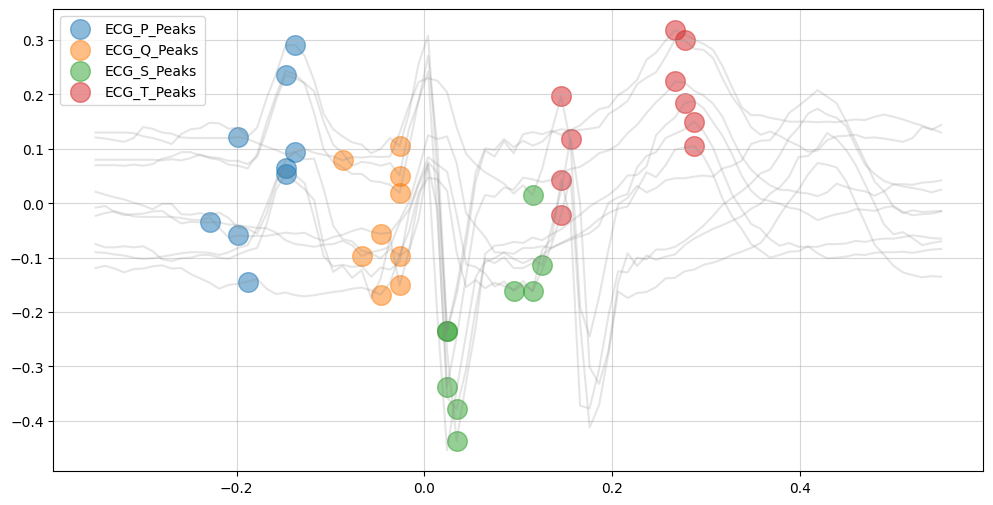

In [80]:
signal_dwt, waves_dwt = nk.ecg_delineate(ecg, 
                                        rpeaks, 
                                        sampling_rate=100, 
                                        method="dwt", 
                                        show=True, 
                                        show_type='peaks')

In [38]:
waves_dwt

{'ECG_P_Peaks': [60, 142, 226, 310, 393, 476, 559, 640, 722, 804, 885, 969],
 'ECG_P_Onsets': [53, 136, 220, 305, 387, 470, 553, 634, 716, 798, 879, 963],
 'ECG_P_Offsets': [66, 149, 233, 317, 400, 483, 565, 646, 728, 810, 891, 975],
 'ECG_Q_Peaks': [68, 151, 235, 319, 401, 485, 567, 648, 730, 812, 893, nan],
 'ECG_R_Onsets': [61, 144, 227, 311, 395, 477, 560, 641, 723, 805, 886, nan],
 'ECG_R_Offsets': [80, 163, 247, 331, 414, 497, 580, 660, 742, 825, 906, nan],
 'ECG_S_Peaks': [77, 160, 244, 328, 411, 494, 576, 657, 739, 821, 902, nan],
 'ECG_T_Peaks': [98, 181, 265, 349, 432, 516, 598, 679, 761, 843, 924, nan],
 'ECG_T_Onsets': [90, 173, 258, 342, 424, 507, 590, 670, 753, 835, 917, nan],
 'ECG_T_Offsets': [107, 191, 274, 358, 441, 524, 607, 687, 769, 853, 933, nan]}

In [17]:
rpeaks_array = rpeaks['ECG_R_Peaks']
rpeaks_array

array([ 81, 171, 269, 368, 466, 564, 659, 755, 852, 951])

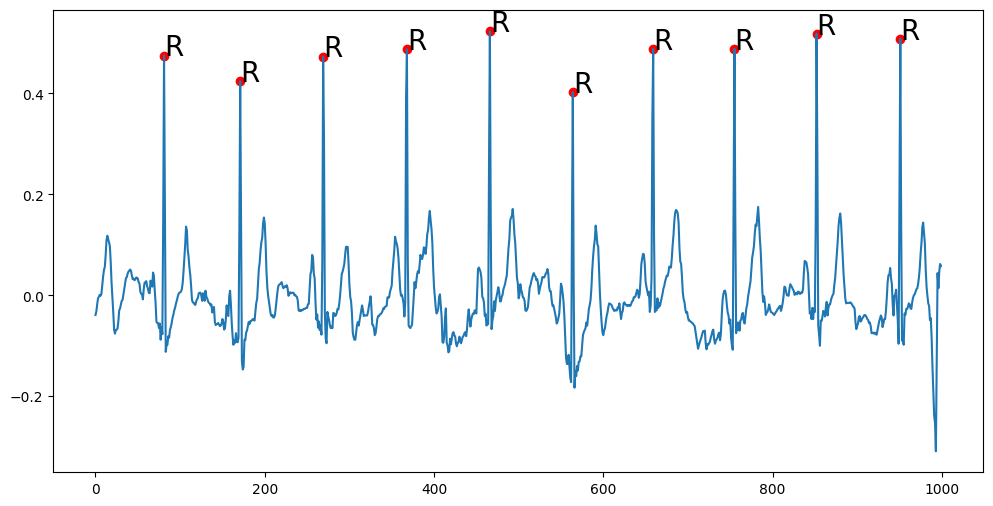

In [18]:
# Check whether R wave detection is correct
# plt.rcParams["axes.grid"] = True
# plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
plt.plot(ecg)
for i in range(len(rpeaks_array)):
    plt.scatter(rpeaks_array[i], ecg[rpeaks_array[i]],c='r')
    plt.annotate('R',(rpeaks_array[i], ecg[rpeaks_array[i]]), fontsize=20)
plt.show()

In [25]:
import neurokit2 as nk
# piecewise function
def splitByR(ecg):
    _, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100)
    _, waves_peak = nk.ecg_delineate(ecg, rpeaks, sampling_rate=100, method="peak")
    index = rpeaks['ECG_R_Peaks']
    ecg_rhythm = None
    for i in range(len(index)):
        # extract a section
        # if index[i]>200 and index[i]<1000-350:
        #     ecg_rhythm = ecg[index[i]-150:index[i]+350]
        #     continue
        if index[i]>200 and index[i]<1000-350:
            ecg_rhythm = ecg[index[i]-30:index[i]+70]
            continue
    return ecg_rhythm

In [26]:
ecg_rhythm = splitByR(ecg) 


In [27]:
ecg_rhythm.size

100

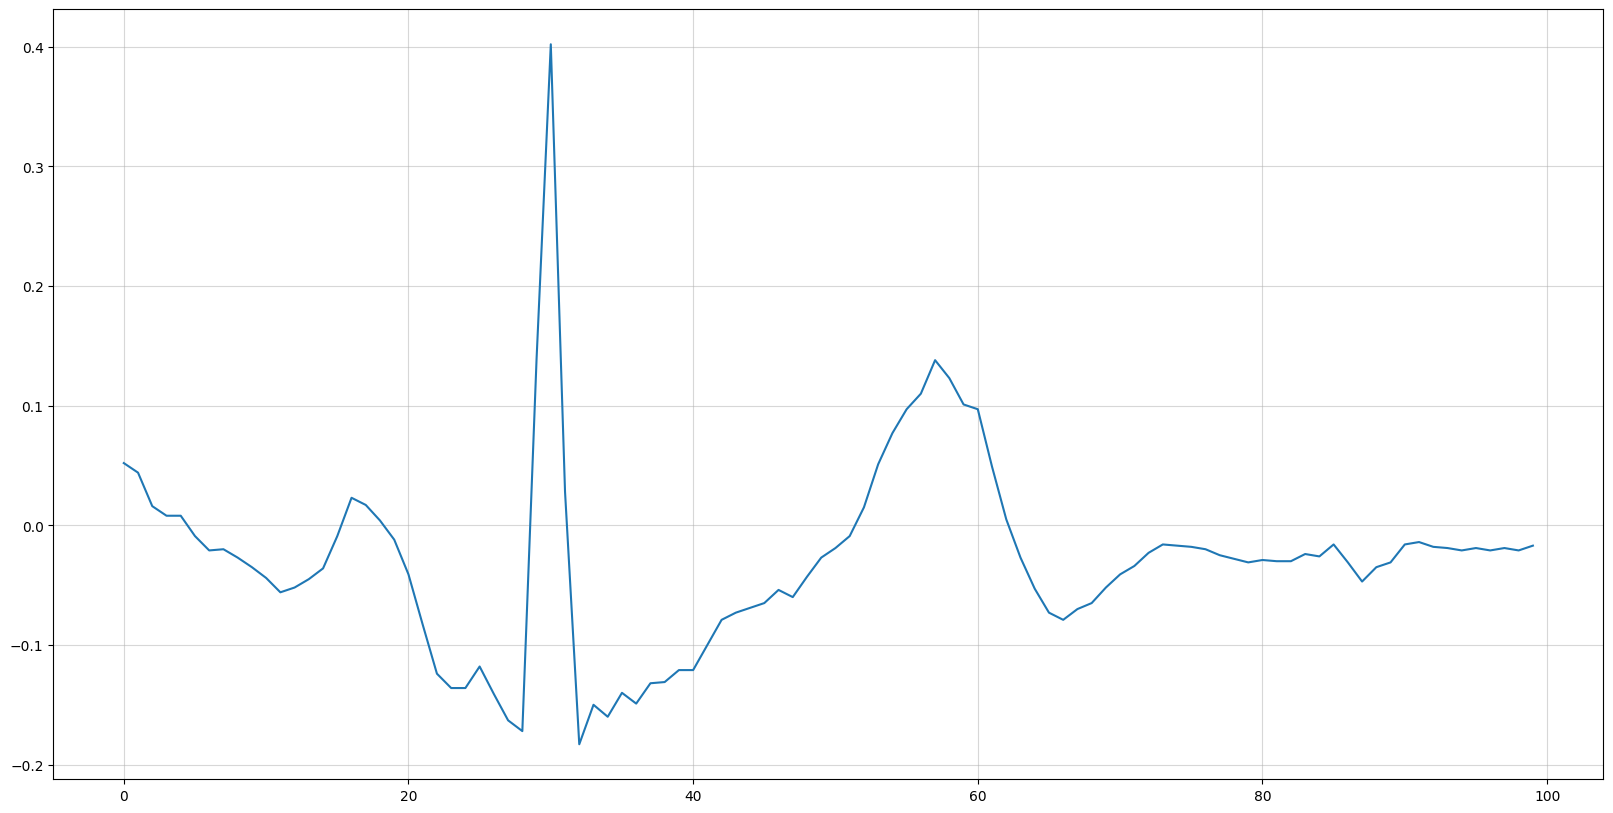

In [28]:

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.rcParams['axes.titlesize'] = 16
plt.figure()
plt.plot(ecg_rhythm)
plt.show()

### TEst ECG segmentation around heart beat

In [32]:
ecg = X[7476][:,0]
_, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100, method='neurokit')

In [34]:
rpeaks_array = rpeaks['ECG_R_Peaks']

In [35]:
ecg = X[7476][:,0]
_, rpeaks = nk.ecg_peaks(ecg, sampling_rate=100, method='neurokit')
# Define a function to create epochs
def extract_heartbeats(ecg_signal, peaks, sampling_rate=None): 
    heartbeats = nk.epochs_create(ecg_signal, 
                                  events=peaks, 
                                  epochs_start=-0.3, 
                                  epochs_end=0.4, 
                                  sampling_rate=sampling_rate)
    heartbeats = nk.epochs_to_df(heartbeats)
    return heartbeats
    
heartbeats = extract_heartbeats(ecg, peaks=rpeaks_array, sampling_rate=100)
heartbeats.head()

Signal  Index Label      Time
0   0.026     51     1 -0.300000
1   0.023     52     1 -0.289855
2   0.007     53     1 -0.279710
3   0.003     54     1 -0.269565
4   0.002     55     1 -0.259420

In [36]:
heartbeats_pivoted = heartbeats.pivot(index='Time', columns='Label', values='Signal')
heartbeats_pivoted.head()

Label          1     10      2      3      4      5      6      7      8  \
Time                                                                       
-0.300000  0.026 -0.074 -0.052 -0.010 -0.035 -0.075  0.052 -0.019 -0.095   
-0.289855  0.023 -0.077 -0.059 -0.030 -0.032 -0.073  0.044 -0.021 -0.092   
-0.279710  0.007 -0.078 -0.057 -0.031 -0.026 -0.081  0.016 -0.019 -0.084   
-0.269565  0.003 -0.069 -0.057 -0.029 -0.027 -0.067  0.008 -0.021 -0.078   
-0.259420  0.002 -0.061 -0.055 -0.031 -0.023 -0.043  0.008 -0.017 -0.071   

Label          9  
Time              
-0.300000  0.019  
-0.289855  0.016  
-0.279710  0.012  
-0.269565  0.009  
-0.259420  0.001

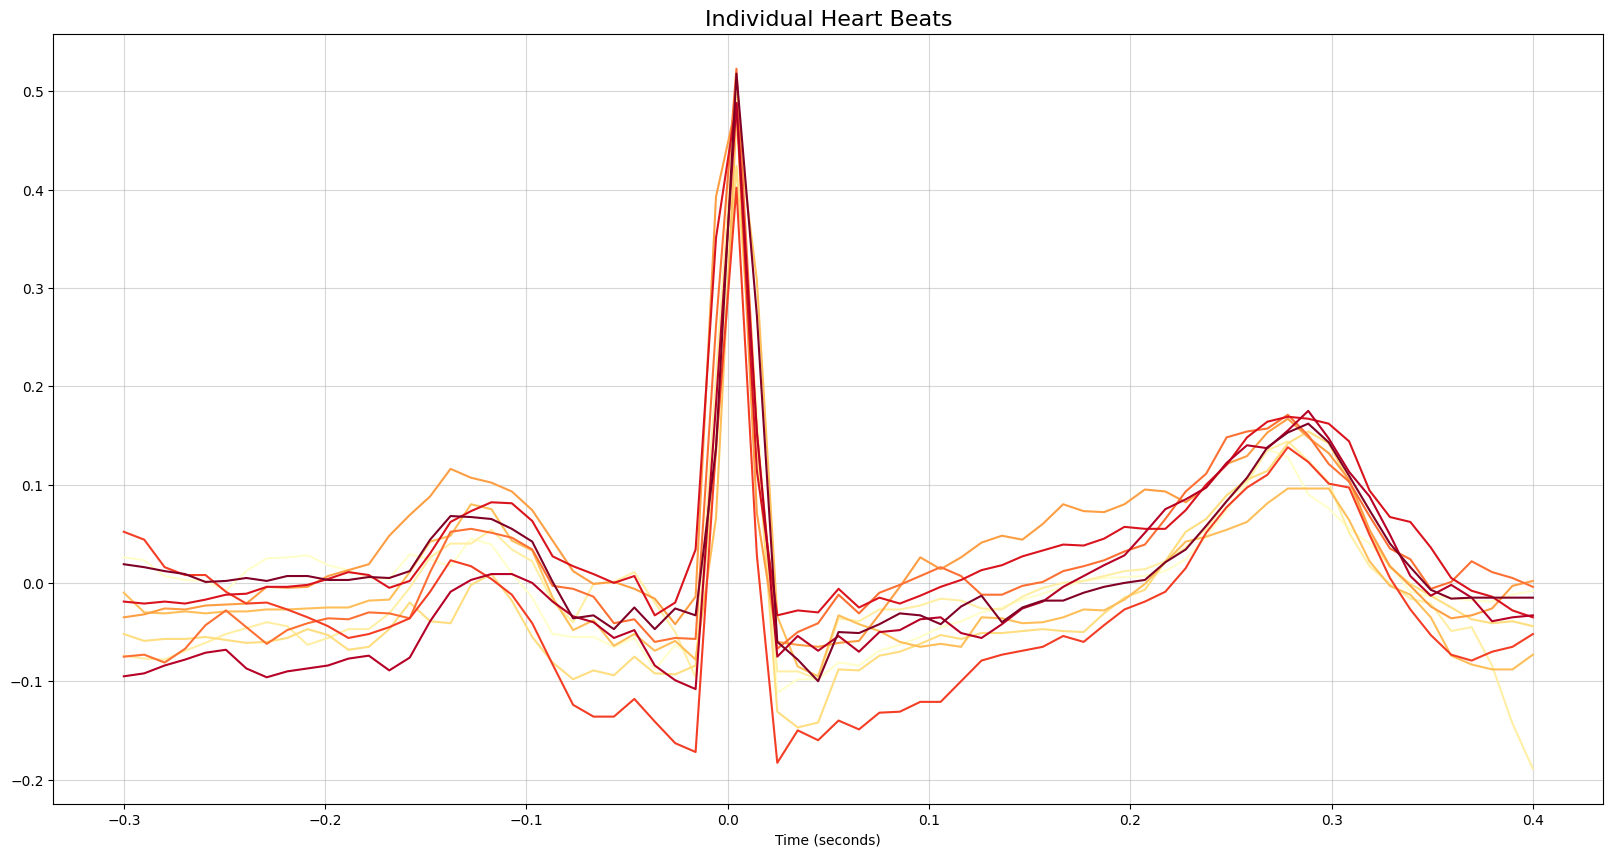

In [37]:
# Prepare figure
fig, ax = plt.subplots()

ax.set_title("Individual Heart Beats")
ax.set_xlabel("Time (seconds)")

# Aesthetics
labels = list(heartbeats_pivoted)
labels = ['Channel ' + x for x in labels] # Set labels for each signal
cmap = iter(plt.cm.YlOrRd(np.linspace(0,1, int(heartbeats["Label"].nunique())))) # Get color map
lines = [] # Create empty list to contain the plot of each signal

for i, x, color in zip(labels, heartbeats_pivoted, cmap):
    line, = ax.plot(heartbeats_pivoted[x], label='%s' % i, color=color)
    lines.append(line)

Segmentation of ECG data: Centered around the R-wave peaks of Lead 2. 

1. The code first identifies the R-wave peaks in each ECG signal using the `detect_r_peaks` function. The R-wave is a prominent feature in an ECG signal that corresponds to the depolarization of the ventricles of the heart.

2. Once the R-wave peaks are identified, the code checks if each R-wave peak is within a specific range. The condition `if R_index[i]>200 and R_index[i]<1000-350` ensures that the R-wave peak is not too close to the beginning or the end of the signal.

3. If an R-wave peak meets the specified condition, the code extracts a segment of ECG data. The extracted segment includes data points from 150 samples before the R-wave peak to 350 samples after the R-wave peak, effectively creating a segment centered around the R-wave.

4. These extracted segments are then stored in the `ecg_rhythms` array. Each row of the `ecg_rhythms` array corresponds to an ECG signal, and each column corresponds to a channel (lead) of the ECG. Therefore, the `ecg_rhythms` array contains multiple segments, each centered around an R-wave peak and spanning all 12 ECG channels.

The code is extracting segments of ECG data that capture the cardiac activity centered around the R-wave peaks, which are crucial landmarks in ECG signals for various types of cardiac analysis and processing.

In [24]:
import neurokit2 as nk
# Extract segments from all channels of all signals
channels = 12
test_size = len(X)
ecg_rhythms = np.zeros([test_size, 100, 12])

# Create an array to store all R-peak locations for your dataset
R_indices = []

start_time = time.time()
first_time = start_time
for index in range(test_size):
    if index%1000 == 0:
        end_time = time.time()
        print("finish %d in %d s\n" % (index, end_time - start_time))
        start_time = time.time()
    # Extract R-peak indices for the current ECG using nk.ecg_peaks
    _, rpeaks = nk.ecg_peaks(X[index][:, 1], sampling_rate=100)
    R_index = rpeaks['ECG_R_Peaks']
    for i in range(len(R_index)):
        # extract a section
        if R_index[i]>200 and R_index[i]<1000-350:
            # ecg_rhythms[index][:, :] = X[index][R_index[i]-150:R_index[i]+350,:]
            ecg_rhythms[index][:, :] = X[index][R_index[i]-30:R_index[i]+70,:]
            # ecg_rhythms[index][:, :] = X[index][R_index[i]-130:R_index[i]+170,:]
            continue

end_time = time.time()

print('time cost:%d s'%(end_time-first_time))

finish 0 in 0 s

finish 1000 in 2 s

finish 2000 in 1 s

finish 3000 in 1 s

finish 4000 in 1 s

finish 5000 in 1 s

finish 6000 in 1 s

finish 7000 in 1 s

finish 8000 in 1 s

finish 9000 in 1 s

finish 10000 in 1 s

finish 11000 in 1 s

finish 12000 in 1 s

finish 13000 in 0 s

finish 14000 in 0 s

finish 15000 in 0 s

finish 16000 in 0 s

finish 17000 in 1 s

finish 18000 in 1 s

finish 19000 in 1 s

finish 20000 in 1 s

finish 21000 in 1 s

time cost:29 s


In [46]:
ecg_rhythms.shape

(21837, 100, 12)

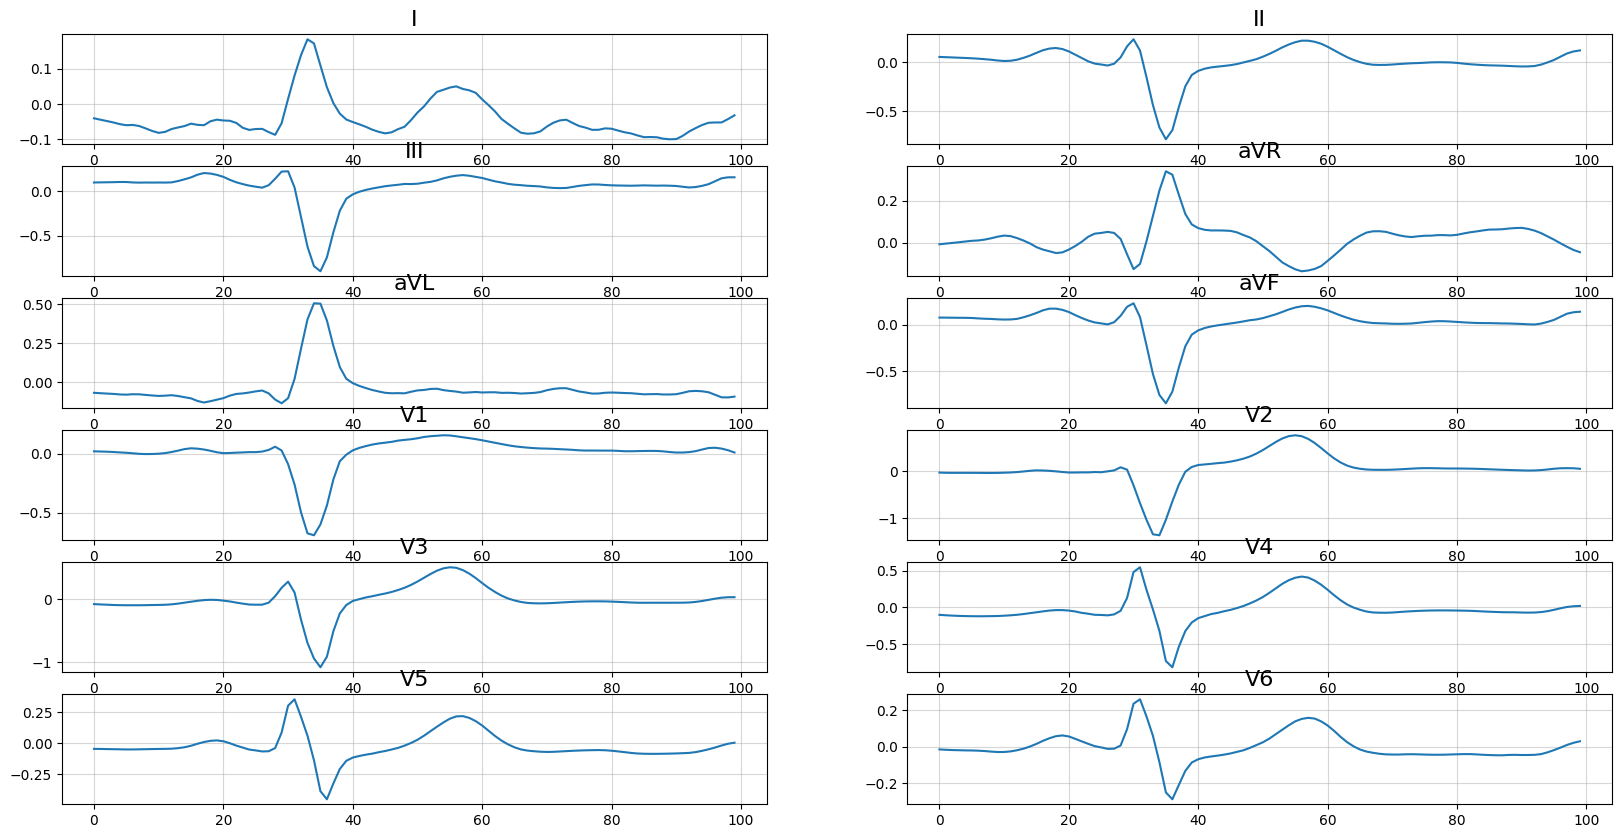

In [54]:
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.figure()
for i in range(12):
    plt.subplot(6, 2, i+1)
    plt.plot(ecg_rhythms[40,:,i])
    plt.title(titles[i])
plt.show()

In [39]:
# false_count = 0
# Y['Runconfirmed'] = 0
# for index in range(len(ecg_rhythms)):
#     if ecg_rhythms[index].any() == np.zeros([500, 12]).any():
#         false_count += 1
#         Y['Runconfirmed'][index] = 1
# false_count

C:\Users\ROG\AppData\Local\Temp\ipykernel_2584\2216112086.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Runconfirmed'][index] = 1


2598


## Divide the data set

In [75]:
# Split data into train and test
test_fold = 10
# # Train
X_train = ecg_rhythms[(Y.strat_fold <= 8)]
y_train = Z[Y.strat_fold <= 8]
# # Test
X_test = ecg_rhythms[(Y.strat_fold >8)]
y_test = Z[Y.strat_fold > 8]

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(17441, 100, 12) (17441, 5)
(4396, 100, 12) (4396, 5)


In [56]:
save_path = 'D:/Test Jupyter/ECG-Classfier-main/data/numpy_data/'

np.save(save_path+'X_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'X_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))

In [57]:
y_test

NORM  MI  STTC  CD  HYP
ecg_id                         
8          0   1     0   0    0
9          1   0     0   0    0
10         1   0     0   0    0
17         0   0     0   0    0
18         0   0     0   0    0
...      ...  ..   ...  ..  ...
21818      1   0     0   0    0
21819      0   0     0   1    0
21826      0   1     0   0    0
21831      1   0     0   0    0
21837      1   0     0   0    0

[4396 rows x 5 columns]

In [58]:
distinct_values_counts = y_train.value_counts()
print(distinct_values_counts)

NORM  MI  STTC  CD  HYP
1     0   0     0   0      7254
0     1   0     0   0      2048
      0   1     0   0      1907
          0     1   0      1353
      1   0     1   0      1038
      0   1     0   1       650
      1   1     0   0       475
      0   0     0   1       416
          1     1   0       387
          0     0   0       330
1     0   0     1   0       327
0     1   1     0   1       282
      0   0     1   1       235
      1   1     1   0       177
      0   1     1   1       168
      1   0     0   1       146
          1     1   1       123
          0     1   1        99
1     0   1     0   0        20
                1   0         4
          0     0   1         1
      1   0     1   1         1
dtype: int64


In [51]:

import pywt
import seaborn as sns
import scaleogram as scg 
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from scipy.fftpack import fft

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


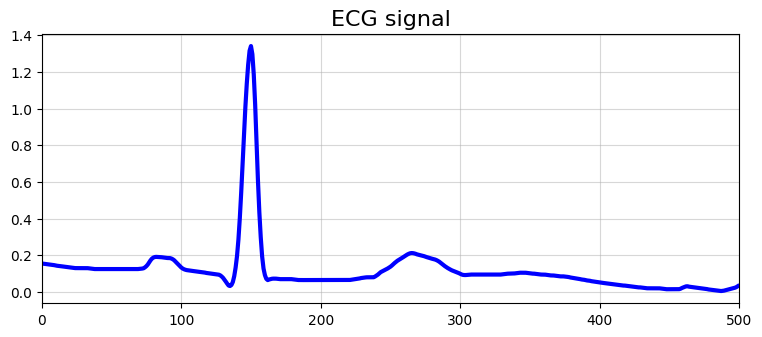

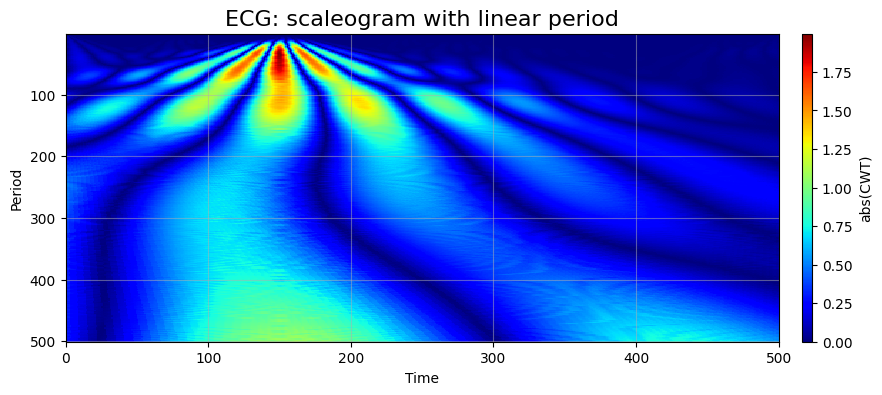

In [66]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

nn = 40
signal_length = 500
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(ecg_rhythms[nn][:,1]),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg_rhythms[nn][:,1], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title("ECG signal")

# the scaleogram
scg.cws(ecg_rhythms[nn][:,1][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title='ECG: scaleogram with linear period'); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


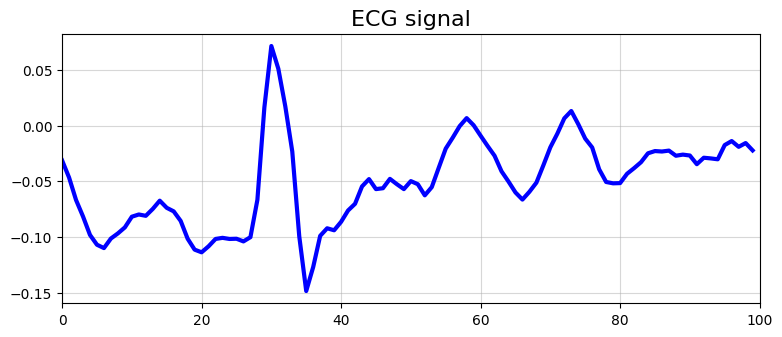

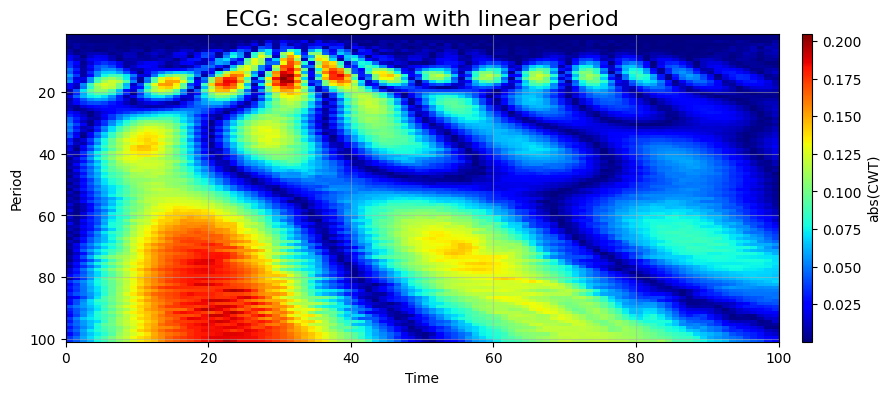

In [57]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

nn = 12567
signal_length = 100
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(ecg_rhythms[nn][:,1]),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg_rhythms[nn][:,1], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title("ECG signal")

# the scaleogram
scg.cws(ecg_rhythms[nn][:,1][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title='ECG: scaleogram with linear period'); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

 In vertical axe we plot the period (defined above), in the horizontal axe we show the scale, there is a relationship between scale and period mediated by the central frequency,  a parameter of the chosen wavelet,  frequency  = b/s.

We can interpret each horizontal characteristic in the scaleogram as a frequency of the total signal. The fact of not seeing a continuous line in our figure corresponds to that said frequencies are not continuous in time.

## CWT on a single lead

In [72]:
# Choose the lead you want to process (0 to 11)
selected_lead = 1  # You can change this value

# Set the default wavelet function
scg.set_default_wavelet('morl')
waveletname='morl'

# Define the signal length
signal_length = 100

# Range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, signal_length + 1))

# Create an array to store the CWT coefficients for all records
cwt_coefficients = []

# Loop through all records and perform CWT for the selected lead
for record in ecg_rhythms:
    signal = record[:, selected_lead][:signal_length]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    cwt_coefficients.append(coeff)

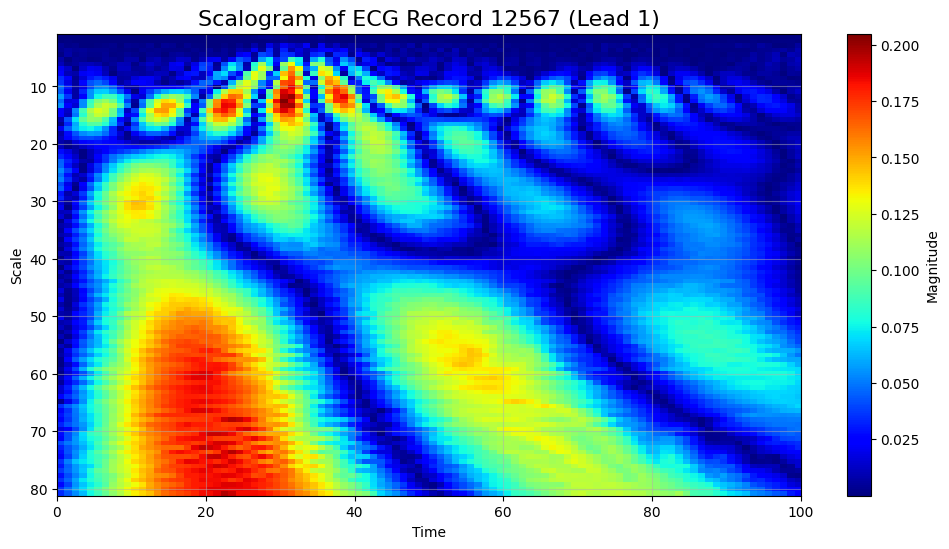

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


In [73]:
# Choose the index of the record you want to plot
record_index_to_plot = 12567  # You can change this index

# Plot the selected record after the CWT loop
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(cwt_coefficients[record_index_to_plot]), extent=[0, signal_length, scales[-1], scales[0]],
           aspect='auto', cmap='jet')
plt.title(f'Scalogram of ECG Record {record_index_to_plot} (Lead {selected_lead})')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.colorbar(label='Magnitude')
plt.show()

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

In [75]:
# Convert cwt_coefficients to a NumPy array
cwt_array = np.array(cwt_coefficients)

# Check the shape of cwt_array
shape = cwt_array.shape

print(f'Shape of cwt_coefficients: {shape}')

Shape of cwt_coefficients: (21837, 100, 100)


In [81]:
import numpy as np
import pywt
import scaleogram as scg
import matplotlib.pyplot as plt

# Choose the lead you want to process (0 to 11)
selected_lead = 1  # You can change this value

# Set the default wavelet function
scg.set_default_wavelet('morl')
waveletname = 'morl'

# Define the signal length
signal_length = 100

# Range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, signal_length + 1))

# Create an array to store the CWT coefficients as RGB values for all records
cwt_coefficients = []

# Loop through all records and perform CWT for the selected lead
for record in ecg_rhythms:
    signal = record[:, selected_lead][:signal_length]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    
    # Map CWT coefficients to RGB colors using a colormap (e.g., 'viridis')
    rgb_coeff = plt.cm.viridis(np.abs(coeff) / np.max(np.abs(coeff)))[:, :, :3]  # Map to RGB and remove alpha
    
    cwt_coefficients.append(rgb_coeff)

C:\Users\ROG\AppData\Local\Temp\ipykernel_18996\3901712168.py:27: RuntimeWarning: invalid value encountered in divide
  rgb_coeff = plt.cm.viridis(np.abs(coeff) / np.max(np.abs(coeff)))[:, :, :3]  # Map to RGB and remove alpha


In [82]:
# Convert cwt_coefficients to a NumPy array
cwt_array = np.array(cwt_coefficients)

# Check the shape of cwt_array
shape = cwt_array.shape

print(f'Shape of cwt_coefficients: {shape}')

Shape of cwt_coefficients: (21837, 100, 100, 3)


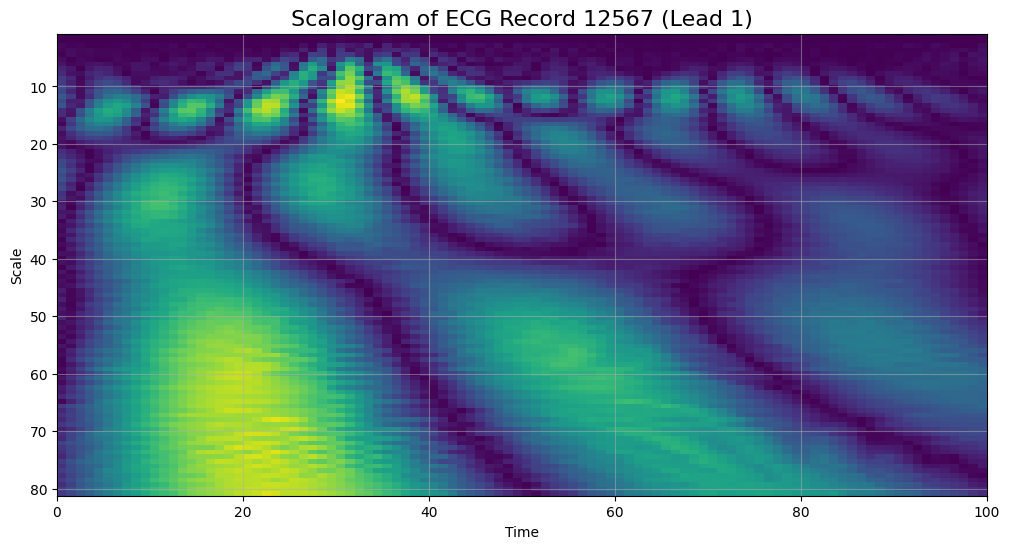

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


In [83]:

# Choose the index of the record you want to plot
record_index_to_plot = 12567  # You can change this index


# Plot the selected record after the CWT loop
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(cwt_coefficients[record_index_to_plot]), extent=[0, signal_length, scales[-1], scales[0]],
           aspect='auto')
plt.title(f'Scalogram of ECG Record {record_index_to_plot} (Lead {selected_lead})')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")


In [84]:
# Split data into train and test
test_fold = 10
# # Train
X_train = cwt_array[(Y.strat_fold <= 8)]
y_train = Z[Y.strat_fold <= 8]
# # Test
X_test = cwt_array[(Y.strat_fold >8)]
y_test = Z[Y.strat_fold > 8]

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(17441, 100, 100, 3) (17441, 5)
(4396, 100, 100, 3) (4396, 5)


In [65]:
save_path = 'D:/Test Jupyter/ECG-Classfier-main/data/numpy_data_lead2_cwt/'

np.save(save_path+'X_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'X_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))

## CWT on all leads and merged

In [47]:
import numpy as np
import pywt
import scaleogram as scg
import matplotlib.pyplot as plt

# Set the default wavelet function
scg.set_default_wavelet('morl')

# Define the signal length
signal_length = 100

# Range of scales to perform the transform
scales = scg.periods2scales(np.arange(1, signal_length + 1))

# Create an array to store the CWT coefficients for all records
cwt_coefficients = []


# Loop through all records
for record in ecg_rhythms:
    # Create an array to store the CWT coefficients for all leads of the current record
    cwt_coefficients_record = []

    # Loop through all leads
    for selected_lead in range(12):
        signal = record[:, selected_lead][:signal_length]
        coeff, freq = pywt.cwt(signal, scales, scg.get_default_wavelet(), 1)
        cwt_coefficients_record.append(coeff)

    # Merge the CWT coefficients of all leads into a single image
    # merged_coefficients = np.stack(cwt_coefficients_record, axis=-1)

    # cwt_coefficients.append(merged_coefficients)

    # Append the coefficients for all leads to the list
    cwt_coefficients.append(cwt_coefficients_record)

C:\Users\ROG\AppData\Local\Temp\ipykernel_348\3181176414.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


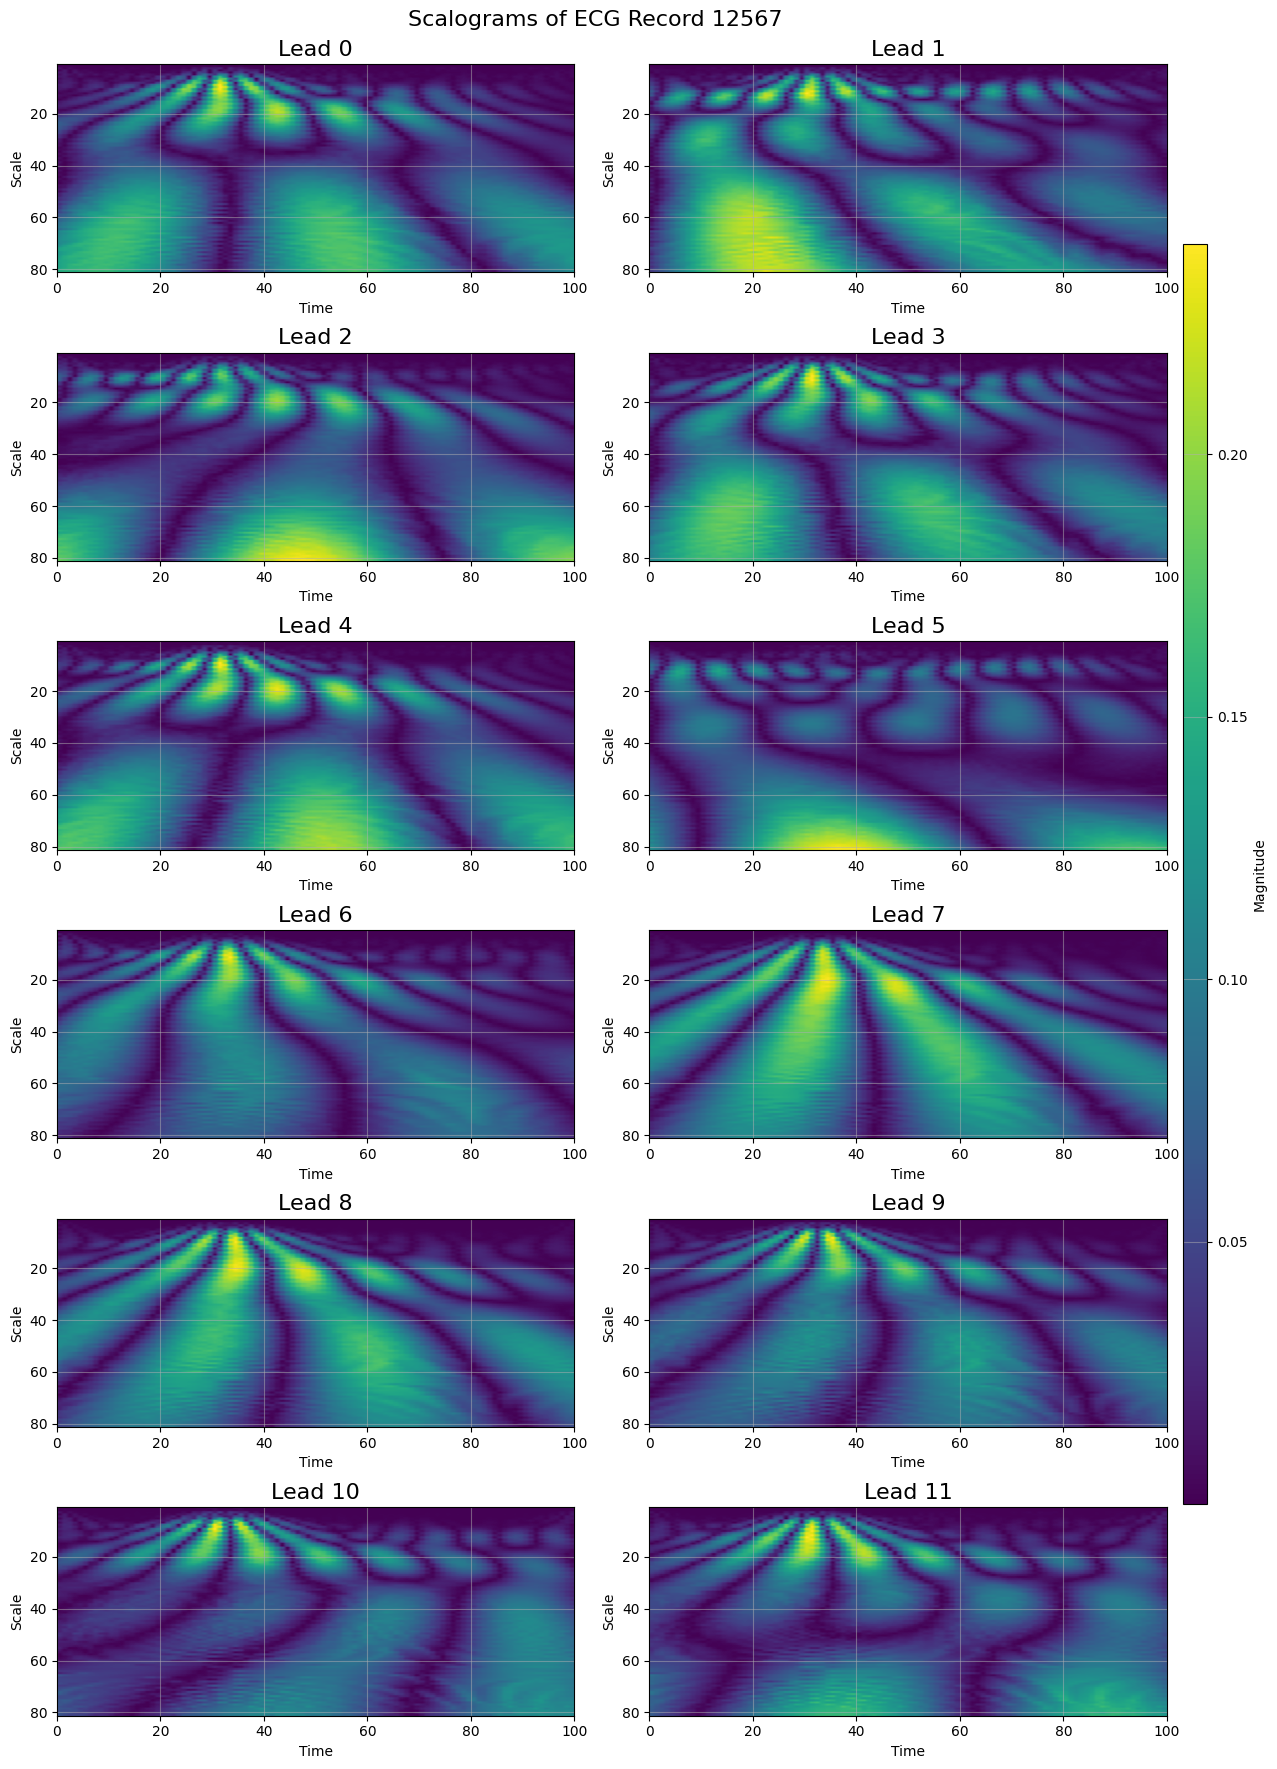

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


In [48]:
# Choose the index of the record you want to plot
record_index_to_plot = 12567  # You can change this index

# Number of rows and columns for subplots
num_rows = 6
num_columns = 2

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 18))

for lead_index, coeff in enumerate(cwt_coefficients[record_index_to_plot]):
    row = lead_index // num_columns
    col = lead_index % num_columns
    im = axes[row, col].imshow(np.abs(coeff), extent=[0, signal_length, scales[-1], scales[0]], aspect='auto')
    axes[row, col].set_title(f'Lead {lead_index}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Scale')

# Add color bar to the right of the subplots
cbar_ax = fig.add_axes([0.99, 0.15, 0.02, 0.7])  # Define the position of the color bar
cbar = plt.colorbar(im, cax=cbar_ax, label='Magnitude')


plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the space for the suptitle
plt.suptitle(f'Scalograms of ECG Record {record_index_to_plot}', fontsize=16)

plt.show()

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")


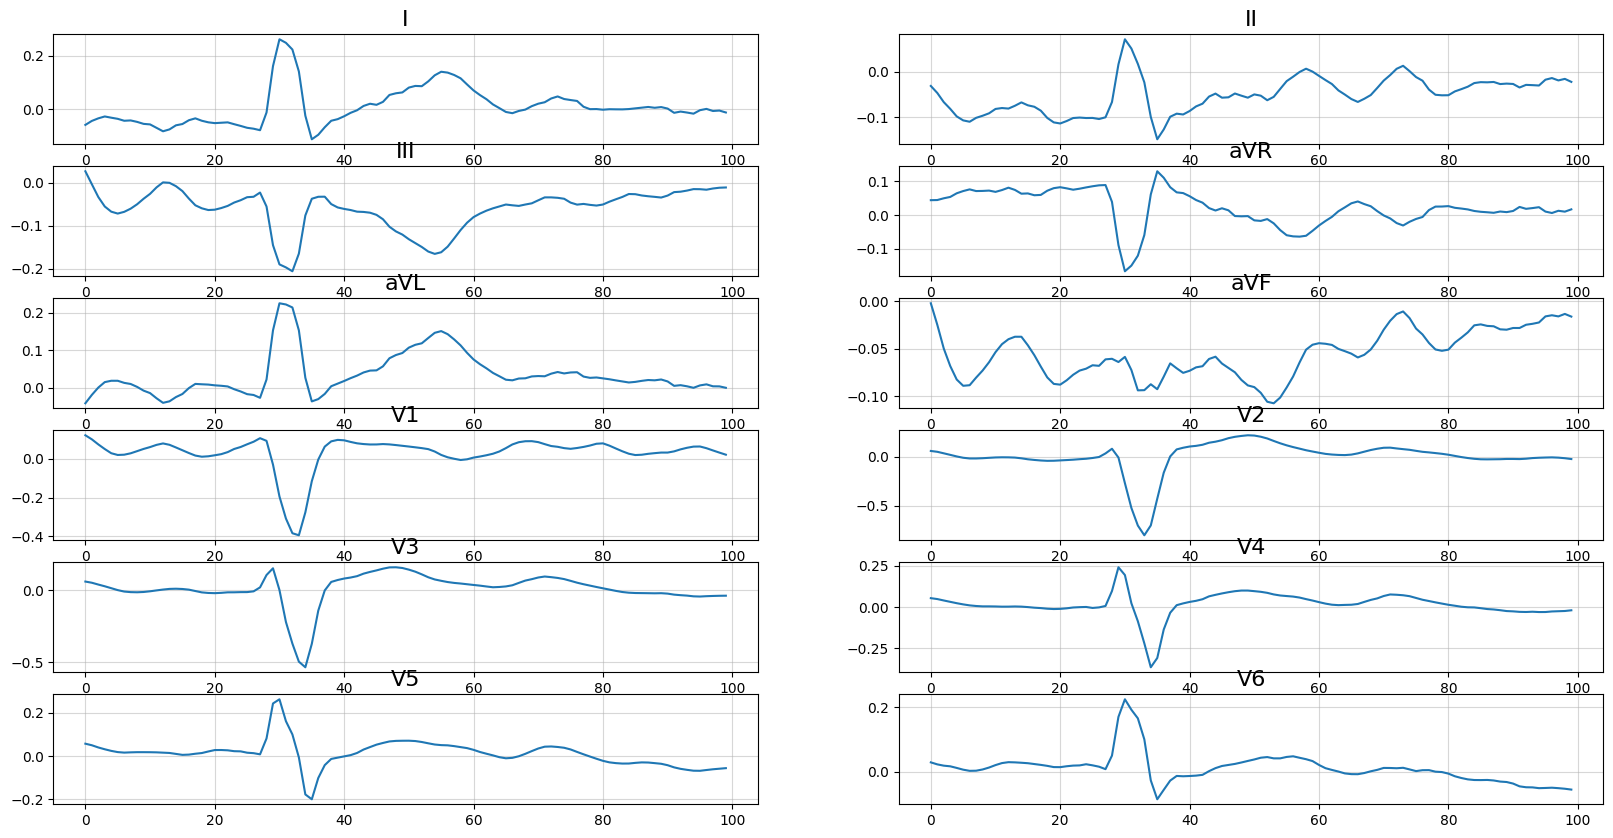

In [57]:
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.figure()
for i in range(12):
    plt.subplot(6, 2, i+1)
    plt.plot(ecg_rhythms[12567,:,i])
    plt.title(titles[i])
plt.show()

In [49]:

# Convert cwt_coefficients to a NumPy array
cwt_array = np.array(cwt_coefficients, dtype=np.float32)

In [50]:
# Check the shape of cwt_array
shape = cwt_array.shape

print(f'Shape of cwt_coefficients: {shape}')

Shape of cwt_coefficients: (21837, 12, 100, 100)


In [51]:
# Transpose the array to (21837, 100, 100, 12)
cwt_array_transpose = np.transpose(cwt_array, (0, 2, 3, 1))

In [52]:
# Split data into train and test
# # Train
X_train = cwt_array_transpose[(Y.strat_fold <= 8)]
y_train = Z[Y.strat_fold <= 8]
# # Test
X_test = cwt_array_transpose[(Y.strat_fold >8)]
y_test = Z[Y.strat_fold > 8]

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

MemoryError: Unable to allocate 7.80 GiB for an array with shape (17441, 100, 100, 12) and data type float32

In [62]:
save_path = 'D:/Test Jupyter/ECG-Classfier-main/data/numpy_data_12lead_cwt/'

np.save(save_path+'X_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'X_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))